In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import json
import pandas as pd
import re
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from transformers import T5Tokenizer, AutoTokenizer, T5ForConditionalGeneration, get_linear_schedule_with_warmup, get_scheduler, T5TokenizerFast
import torch
from torch.optim import AdamW
from tqdm import tqdm
import os
import numpy as np

# Loading data and revise the spoiler position info.

In [3]:
# Loading data.
train_path = '/content/drive/My Drive/Colab Notebooks/Model2.1-phrase/train_phrase.json'
val_path = '/content/drive/My Drive/Colab Notebooks/Model2.1-phrase/val_phrase.json'
test_path = '/content/drive/My Drive/Colab Notebooks/Model2.1-phrase/test_phrase.jsonl'

def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_jsonl(train_path)
val_data = load_jsonl(val_path)
test_data = load_jsonl(test_path)

# Checking the data.
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 1367
Validation samples: 162
Test samples: 165


In [5]:
# Merge targetTitle to the beginning of targetParagraphs and update its para_idx if spoilerPositions exists (overall +1).
def merge_title_into_paragraphs(data):
    for item in data:
        title = item.get("targetTitle", "")
        paragraphs = item.get("targetParagraphs", [])
        item["targetParagraphs"] = [title] + paragraphs

        if "spoilerPositions" not in item:
            continue

        new_positions = []
        for start_pos, end_pos in item["spoilerPositions"]:
            para_idx_start, char_start = start_pos
            para_idx_end, char_end = end_pos

            para_idx_start = para_idx_start + 1 if para_idx_start != -1 else 0
            para_idx_end = para_idx_end + 1 if para_idx_end != -1 else 0

            new_positions.append([[para_idx_start, char_start], [para_idx_end, char_end]])

        item["spoilerPositions"] = new_positions
    return data

train_data = merge_title_into_paragraphs(train_data)
val_data = merge_title_into_paragraphs(val_data)
test_data = merge_title_into_paragraphs(test_data)

In [7]:
# Dealing with misaligned spoilerPositions.
target_uuid = "49b507af-9153-451f-8ec2-f73ee6f7861b"
new_spoiler_positions = [[[1, 0], [1, 22]]]
for item in train_data:
    if item.get("uuid") == target_uuid:
        item["spoilerPositions"] = new_spoiler_positions
        break
else:
    print("❌ UUID not found in dataset.")

target_uuid = "d7b0ffc1-8c35-4879-86e6-67d12ad5ee30"
new_spoiler_positions = [[[1, 22], [1, 27]]]
for item in train_data:
    if item.get("uuid") == target_uuid:
        item["spoilerPositions"] = new_spoiler_positions
        break
else:
    print("❌ UUID not found.")

target_uuid = "635d1391-4e07-4ac7-8602-aff67b2d1526"
new_spoiler_positions = [[[1, 0], [2, 41]]]
for item in train_data:
    if item.get("uuid") == target_uuid:
        item["spoilerPositions"] = new_spoiler_positions
        break
else:
    print("❌ UUID not found.")

uuid_target = "635d1391-4e07-4ac7-8602-aff67b2d1526"
for item in train_data:
    if item.get("uuid") == uuid_target:
        # 拼接段[1]和[2]
        para1 = item["targetParagraphs"][1].strip()
        para2 = item["targetParagraphs"][2].strip()
        merged = f"{para1} {para2}"

        # 替换段落并删除原段[2]
        item["targetParagraphs"][1] = merged
        del item["targetParagraphs"][2]

        # 更新 spoilerPositions
        spoiler = item["spoiler"][0] if isinstance(item["spoiler"], list) else item["spoiler"]
        start_char = merged.find(spoiler)
        end_char = start_char + len(spoiler)
        item["spoilerPositions"] = [[[1, start_char], [1, end_char]]]

        print("✅ Updated sample:")
        print(f"UUID: {uuid_target}")
        print(f"New spoilerPositions: {item['spoilerPositions']}")
        print(f"Updated paragraph[1]:\n{item['targetParagraphs'][1]}")
        break

✅ Updated sample:
UUID: 635d1391-4e07-4ac7-8602-aff67b2d1526
New spoilerPositions: [[[1, 0], [1, 40]]]
Updated paragraph[1]:
The Hundred-Year House by Rebecca Makkai


# check spoiler position align condition.

In [16]:
def check_spoiler_alignment(data):
    mismatches = []
    cross_span_samples = 0
    cross_span_mismatches = 0
    normal_mismatches = 0
    total_checked = 0
    skipped_samples = []

    for i, item in enumerate(data):
        extracted_spoilers = []
        all_single_span = True
        skip_this = False

        for start_pos, end_pos in item.get("spoilerPositions", []):
            para_idx_start, char_start = start_pos
            para_idx_end, char_end = end_pos
            if para_idx_start != para_idx_end:
                cross_span_samples += 1
                all_single_span = False
                break
            if para_idx_start == -1:
                paragraph = item.get("postText", "")
            elif para_idx_start >= 0:
                paragraphs = item.get("targetParagraphs", [])
                if para_idx_start < len(paragraphs):
                    paragraph = paragraphs[para_idx_start]
                else:
                    skip_this = True
                    break
            else:
                skip_this = True
                break
            try:
                extracted = paragraph[char_start:char_end]
                extracted_spoilers.append(extracted.strip())
            except Exception:
                skip_this = True
                break

        if skip_this:
            skipped_samples.append(i)
            continue

        if not all_single_span:
            raw_spoiler = item.get("spoiler", "")
            gold_spoiler = raw_spoiler[0].strip() if isinstance(raw_spoiler, list) else raw_spoiler.strip()

            if gold_spoiler not in extracted_spoilers:
                mismatches.append((i, gold_spoiler, extracted_spoilers))
                cross_span_mismatches += 1
            continue

        total_checked += 1
        raw_spoiler = item.get("spoiler", "")
        gold_spoiler = raw_spoiler[0].strip() if isinstance(raw_spoiler, list) else raw_spoiler.strip()

        if gold_spoiler not in extracted_spoilers:
            mismatches.append((i, gold_spoiler, extracted_spoilers))
            normal_mismatches += 1

    print("Total samples:", len(data))
    print("Checked:", total_checked)
    print("Cross-span samples:", cross_span_samples)
    print("Skipped samples (invalid/errored):", len(skipped_samples))
    print("Skipped indices:", skipped_samples)
    print("Total mismatches:", len(mismatches))
    print("   ├─ Cross-span mismatches:", cross_span_mismatches)
    print("   └─ Normal mismatches:", normal_mismatches)
    print(f"Alignment accuracy: {100 - len(mismatches)/total_checked * 100:.2f}%")

    return mismatches, skipped_samples

In [17]:
mismatches, skipped_samples = check_spoiler_alignment(train_data)

Total samples: 1367
Checked: 1367
Cross-span samples: 0
Skipped samples (invalid/errored): 0
Skipped indices: []
Total mismatches: 0
   ├─ Cross-span mismatches: 0
   └─ Normal mismatches: 0
Alignment accuracy: 100.00%


In [18]:
mismatches = check_spoiler_alignment(val_data)

Total samples: 162
Checked: 162
Cross-span samples: 0
Skipped samples (invalid/errored): 0
Skipped indices: []
Total mismatches: 0
   ├─ Cross-span mismatches: 0
   └─ Normal mismatches: 0
Alignment accuracy: 100.00%


# pre-processing data.

In [21]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

In [22]:
# Extract text of appropriate length from targetparagraph.
def prepare_t5_input(sample, max_tokens=512, instruction_prefix="Generate a spoiler phrase. Post: "):
    post_text = sample["postText"][0]
    paragraphs = sample["targetParagraphs"]
    spoiler_positions = sample.get("spoilerPositions", [])

    input_text = instruction_prefix + post_text
    input_tokens = tokenizer.encode(input_text, add_special_tokens=False)

    try:
        para_pos = spoiler_positions[0]
        if isinstance(para_pos[0], list):  # [[[x,y],[x,y]]]
            spoiler_para_idx = para_pos[0][0]
        else:  # [[x,y],[x,y]]
            spoiler_para_idx = para_pos[0]
    except Exception:
        return input_text

    if spoiler_para_idx < 0 or spoiler_para_idx >= len(paragraphs):
        return input_text

    current_paragraphs = [paragraphs[spoiler_para_idx]]
    new_text = input_text + " " + " ".join(current_paragraphs)
    new_token_len = len(tokenizer.encode(new_text, add_special_tokens=False))

    if new_token_len > max_tokens:
        truncated_spoiler = tokenizer.decode(
            tokenizer.encode(paragraphs[spoiler_para_idx], add_special_tokens=False)[: (max_tokens - len(input_tokens))]
        )
        return input_text + " " + truncated_spoiler

    left_idx = spoiler_para_idx - 1
    right_idx = spoiler_para_idx + 1
    toggle = True

    while True:
        can_add_left = left_idx >= 0
        can_add_right = right_idx < len(paragraphs)

        if not can_add_left and not can_add_right:
            break

        added = False

        if toggle and can_add_left:
            candidate = [paragraphs[left_idx]] + current_paragraphs
            candidate_text = input_text + " " + " ".join(candidate)
            if len(tokenizer.encode(candidate_text, add_special_tokens=False)) <= max_tokens:
                current_paragraphs = candidate
                left_idx -= 1
                added = True
            else:
                left_idx = -1

        elif not toggle and can_add_right:
            candidate = current_paragraphs + [paragraphs[right_idx]]
            candidate_text = input_text + " " + " ".join(candidate)
            if len(tokenizer.encode(candidate_text, add_special_tokens=False)) <= max_tokens:
                current_paragraphs = candidate
                right_idx += 1
                added = True
            else:
                right_idx = len(paragraphs)

        if not added:
            toggle = not toggle
            continue

        toggle = not toggle

    final_input_text = input_text + " Content: " + " ".join(current_paragraphs)
    return final_input_text

train_inputs = [prepare_t5_input(s) for s in tqdm(train_data, desc="Processing Train")]
val_inputs = [prepare_t5_input(s) for s in tqdm(val_data, desc="Processing Val")]

Processing Val: 100%|██████████| 162/162 [00:01<00:00, 130.77it/s]


In [25]:
#Pre-processing data.
def prepare_data(data, split='train'):
    output = []
    for sample in tqdm(data, desc=f"Preparing {split}"):
        input_text = prepare_t5_input(sample)
        target_text = sample['spoiler']  # 这个字段是phrase
        output.append({
            'input_text': input_text,
            'target_text': target_text})
    return output

class SpoilerDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_input_len=512, max_target_len=64):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_enc = self.tokenizer(
            item['input_text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_input_len,
            return_tensors='pt')

        target_enc = self.tokenizer(
            item['target_text'],
            padding='max_length',
            truncation=True,
            max_length=self.max_target_len,
            return_tensors='pt')

        labels = target_enc.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_enc.input_ids.squeeze(),
            "attention_mask": input_enc.attention_mask.squeeze(),
            "labels": labels}

train_data_list = prepare_data(train_data, split='train')
val_data_list = prepare_data(val_data, split='val')

train_dataset = SpoilerDataset(train_data_list, tokenizer)
val_dataset = SpoilerDataset(val_data_list, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

Preparing val: 100%|██████████| 162/162 [00:01<00:00, 129.17it/s]


# Training.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [27]:
# Set up training configuration.
optimizer = AdamW(model.parameters(), lr=1e-4)

num_epochs = 10

train_losses = []
val_losses = []
rouge_scores = []

patience = 1
patience_counter = 0
best_em = 0.0


===== Epoch 1/10 =====


Training: 100%|██████████| 171/171 [03:09<00:00,  1.11s/it]


✅ Train Loss: 0.8710


Validating: 100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


🧪 Val Loss: 0.5241
✅ Exact Match: 0.5062
💾 New best EM! Saving model to /content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/best_model.pt

===== Epoch 2/10 =====


Training: 100%|██████████| 171/171 [03:08<00:00,  1.10s/it]


✅ Train Loss: 0.3997


Validating: 100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


🧪 Val Loss: 0.5270
✅ Exact Match: 0.5247
💾 New best EM! Saving model to /content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/best_model.pt

===== Epoch 3/10 =====


Training: 100%|██████████| 171/171 [03:08<00:00,  1.10s/it]


✅ Train Loss: 0.2212


Validating: 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


🧪 Val Loss: 0.5738
✅ Exact Match: 0.5123
🛑 Early stopping triggered due to EM not improving.


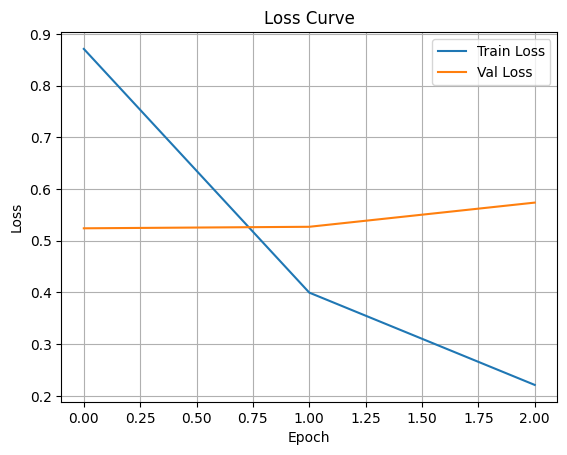

In [28]:
save_path = "/content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/best_model.pt"

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # Train.
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"✅ Train Loss: {avg_train_loss:.4f}")

    # Validation.
    model.eval()
    total_val_loss = 0.0
    generated_texts = []
    reference_texts = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)

            total_val_loss += outputs.loss.item()

            generated = model.generate(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       max_length=32,
                                       length_penalty=0.8,
                                       num_beams=5)

            labels_clean = labels.clone()
            labels_clean[labels_clean == -100] = tokenizer.pad_token_id

            decoded_preds = tokenizer.batch_decode(generated, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels_clean, skip_special_tokens=True)

            generated_texts.extend(decoded_preds)
            reference_texts.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"🧪 Val Loss: {avg_val_loss:.4f}")

    # Exact Match.
    exact_matches = [int(p.strip() == r.strip()) for p, r in zip(generated_texts, reference_texts)]
    exact_match_score = sum(exact_matches) / len(exact_matches)
    print(f"✅ Exact Match: {exact_match_score:.4f}")

    # Save if best EM.
    if exact_match_score >= best_em:
        best_em = exact_match_score
        print(f"💾 New best EM! Saving model to {save_path}")
        torch.save(model, save_path)
    else:
        print("🛑 Early stopping triggered due to EM not improving.")
        break

# Plot Loss Curve.
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# test result generate.

In [29]:
# Load the best em preformance model.
model = torch.load(
    "/content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/best_model_phrase.pt",
    map_location="cuda" if torch.cuda.is_available() else "cpu",
    weights_only=False)
model.eval()

if not hasattr(model, "config"):
    from transformers import T5Config
    model.config = T5Config()

if not hasattr(model.config, "_attn_implementation") or model.config._attn_implementation is None:
    model.config._attn_implementation = ""

In [30]:
# Select the first 15 paragraphs from targetparagraph as testset text input.
def prepare_input_phrase(example, max_length=512):
    post = example['postText'][0]
    paragraphs = example['targetParagraphs']

    selected_paragraphs = paragraphs[:15]
    content = " ".join(selected_paragraphs)
    content = content[:max_length]

    prompt = "Generate a spoiler phrase."
    input_text = f"{prompt} Post: {post} Content: {content}"
    return input_text

def prepare_data(raw_data, split='train'):
    data_list = []
    for example in raw_data:
        input_text = prepare_input_phrase(example)
        data_list.append({
            "uuid": example["uuid"],
            "input_text": input_text,})
    return data_list

In [32]:
# Replace the id column name with uuid to align the preprocessing function.
for item in test_data:
    item["uuid"] = item["id"]
    item.pop("id", None)

In [33]:
# Prepare test set data.
test_data_list = prepare_data(test_data, split='test')

# Generate test set results.
test_results = []

for example in tqdm(test_data_list, desc="Generating Test Results"):
    input_text = example["input_text"]

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=32,
            length_penalty=0.8,
            num_beams=5
        )

    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    test_results.append({
        "id": example["uuid"],
        "spoiler": prediction
    })

Generating Test Results: 100%|██████████| 165/165 [00:42<00:00,  3.92it/s]


In [34]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/P3-orginal.csv"
original_results = pd.read_csv(csv_path)
original_results.head(10)

,id,spoiler
0,0,He decided to surprise his friend with the goo...
1,1,"1. Prioritise - say yes when it matters most.,..."
2,2,meditation inside a beautiful stock-photo room...
3,3,"Braconid, meaning ""any of numerous wasps of th..."
4,4,Cured egg yolks are deliciousbut strong. Becau...
5,5,"John Williams ""Star Wars"" scores"
6,6,"1. Take a long, warm shower with sweet-smellin..."
7,7,Flynn the dog does a lot to help out his 17-ye...
8,8,Lord Ivar Mountbatten has revealed that he is ...
9,9,he coped with putting away too much


In [35]:
# Replacing the results of phrase tag in the general model.
test_df = pd.DataFrame(test_results)

test_df["id"] = test_df["id"].astype(int)
original_results["id"] = original_results["id"].astype(int)
original_results.set_index("id", inplace=True)
test_df.set_index("id", inplace=True)

original_results.update(test_df)
original_results.reset_index(inplace=True)
original_results.head(10)

,id,spoiler
0,0,give them a Kidney
1,1,"1. Prioritise - say yes when it matters most.,..."
2,2,Have a Bunch of Money
3,3,Braconid
4,4,Cured egg yolks
5,5,John Williams
6,6,"1. Take a long, warm shower with sweet-smellin..."
7,7,Flynn the dog does a lot to help out his 17-ye...
8,8,Lord Ivar Mountbatten
9,9,he coped with putting away too much


In [37]:
output_path = "/content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/prediction_task2.csv"
original_results.to_csv(output_path, index=False)

print("Already saved:", output_path)

Already saved: /content/drive/MyDrive/Colab Notebooks/Model2.1-phrase/prediction_task2.csv
